In [1]:
import pandas, keras
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import gc, os
from desy_utils import *

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D
from keras.models import Model
from keras.layers import Concatenate, Add
from keras.optimizers import Adam
from keras.layers import GRU, Bidirectional
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
%%time
(X_train, sclrs), y_train_ft = load_data('train.h5')
gc.collect()
images_train, y_train_img = load_data('train_img.h5', images=True)
gc.collect()

CPU times: user 551 ms, sys: 24.1 ms, total: 575 ms
Wall time: 574 ms


In [4]:
print('image_train:\t',images_train.shape)
print('feat_train:\t',X_train.shape)

image_train:	 (1000, 40, 40, 1)
feat_train:	 (1000, 200, 7)


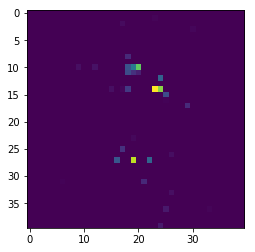

In [5]:
plt.imshow(images_train[400,:,:,0])

In [ ]:
'''
Available models:
> beast.h5 - CNN + RNN + 50 epochs on validation set (a bit tricky Beast that won the chlng)
> cnn.h5 - CNN without any training on validation
> trick_nn.h5 - CNN with lots of training on validation
> rnn.h5 - RNN trained on preprocessed features, didn't do anything good
'''
from keras.models import load_model
model_beast = load_model('networks/beast.h5')

In [7]:
# allows enabling|disabling training for layer weights
for layer in model_beast.layers:
    layer.trainable = True

In [8]:
# example of training with multiple input and usefull callbacks
# roc_auc callback is a bit messy, but still informative
hist_roc = call_roc_hist()
reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1, epsilon=0.002, min_lr=1e-8)
hist = model_beast.fit(x=[images_train, X_train], y=keras.utils.to_categorical(y_train_img), batch_size=512, epochs=3, validation_split=0.1, callbacks=[hist_roc, reducer])

Train on 900 samples, validate on 100 samples
Epoch 1/3
512/900 [================>.............] - ETA: 1s - loss: 0.2304 - acc: 0.9102
Epoch: 0 	roc_auc: 0.9832967032967034 

900/900 [==============================] - 2s - loss: 0.2441 - acc: 0.9078 - val_loss: 0.1880 - val_acc: 0.9600
Epoch 2/3
512/900 [================>.............] - ETA: 0s - loss: 0.2225 - acc: 0.9141
Epoch: 1 	roc_auc: 0.9846153846153847 

900/900 [==============================] - 0s - loss: 0.2400 - acc: 0.8978 - val_loss: 0.1819 - val_acc: 0.9600
Epoch 3/3
512/900 [================>.............] - ETA: 0s - loss: 0.2191 - acc: 0.9023
Epoch: 2 	roc_auc: 0.9841758241758243 

900/900 [==============================] - 0s - loss: 0.2263 - acc: 0.9044 - val_loss: 0.1761 - val_acc: 0.9500


In [9]:
# model parametrs can be changed by hands
from keras import backend as K
K.set_value(model_beast.optimizer.lr, 1e-5)
print(K.get_value(model_beast.optimizer.lr))

1e-05


In [10]:
# Drawing the models scheme into a file
from keras.utils import plot_model
plot_model(model_beast, to_file='beast.png')

In [11]:
_ = '''
# Structure of the CNN model (last output layer is not used when we merge models)

X_input_im = Input(shape=images_train.shape[1:])

X = Conv2D(32, 3, padding='same', activation='relu',input_shape=images_train.shape[1:])(X_input_im)
X = Conv2D(32, 3, padding='same')(X)
#X = BatchNormalization()(X)
X = Activation('relu')(X)
X = MaxPool2D(padding='same')(X)
X = Dropout(rate=0.7)(X)

X = Conv2D(64, 3, padding='same')(X)
#X = BatchNormalization()(X)
X = Activation('relu')(X)
X = MaxPool2D(padding='same')(X)
X = Dropout(rate=0.7)(X)

X_short = X

X = Conv2D(16, 3, padding='same')(X)
#X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(16, 3, padding='same')(X)
#X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(64, 3, padding='same')(X)
#X = BatchNormalization()(X)

X = Add()([X, X_short])
X = Activation('relu')(X)
X = Conv2D(128, 3, padding='same')(X)
#X = BatchNormalization()(X)
X = Activation('relu')(X)
X = MaxPool2D(padding='same')(X)
X = Dropout(rate=0.7)(X)

X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X_out = Dense(2, activation='softmax')(X)

model_cnn = Model(inputs=X_input_im, outputs=X_out)
adamka = Adam(lr=1e-4, decay=1e-6)
model_cnn.compile(optimizer=adamka, loss='binary_crossentropy', metrics=['acc'])


# Structure of the RNN model (last output layer is not used when we merge models)

X_inp_r = Input(shape=(200,7))

X = GRU(16, return_sequences=True)(X_inp_r)
X = Dropout(0.7)(X)

X = GRU(32, return_sequences=True)(X)
X = Dropout(0.7)(X)

X = Flatten()(X)
X = Dense(64, activation='relu')(X)
X = Dense(128, activation='relu')(X)
X_out_t = Dense(2, activation='softmax', name='class')(X)

model_r = Model(inputs=X_inp_r, outputs=X_out_t)
adamka = Adam(lr=1e-4, decay=2e-5)
model_r.compile(optimizer=adamka, loss='binary_crossentropy', metrics=['acc'])


# Merging to models with few additional Dense layers

X = Concatenate()([model_cnn.layers[-2].output, model_r.layers[-2].output])
print(X.shape)
X = Dense(512, activation='relu', name='dense_1_1')(X)
X = Dropout(0.7, name='drop_1_1')(X)
X = Dense(256, activation='relu', name='dense_2_1')(X)
X_out = Dense(2, activation='softmax', name='dense_3_1')(X)

model_beast = Model(inputs=[model_cnn.input, model_r.input], outputs=X_out)
adamka = Adam(lr=1e-3, decay=1e-6)
model_beast.compile(optimizer=adamka, loss='binary_crossentropy', metrics=['acc'])
'''

In [12]:
(X_test, _), y_test_ft = load_data('answ/test_with_truth_100k.h5', scalers=sclrs, training=False, start=None, stop=None)
images_test, y_test_img = load_data('answ/test_with_truth_img_100k.h5', images=True, training=False, start=None, stop=None)

In [13]:
from sklearn.metrics import roc_auc_score
res = model_beast.predict([images_test, X_test], batch_size=512, verbose=1)
roc_auc_score(y_test_img, res[:,1])

100000/100000 [==============================] - 29s    


0.974311908377977

In [14]:
model_beast.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 40, 40, 1)     0                                            
____________________________________________________________________________________________________
conv2d_15 (Conv2D)               (None, 40, 40, 32)    320         input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_16 (Conv2D)               (None, 40, 40, 32)    9248        conv2d_15[0][0]                  
____________________________________________________________________________________________________
activation_13 (Activation)       (None, 40, 40, 32)    0           conv2d_16[0][0]                  
___________________________________________________________________________________________